In [2]:
!pip install ucimlrepo

## Classical Processing

#### This block loads all required libraries for data handling, visualization, classical ML models, metrics, and warning suppression. It also imports the UCI dataset utility and defines the essential tools for training and evaluation. These imports prepare the environment for the full classical + quantum credit-risk pipeline.


In [3]:
# For Classical Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, classification_report)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')


# For Quanutum Processing 
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
import numpy as np
from math import asin, sqrt
from qiskit_ibm_runtime.fake_provider import FakeParisV2
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

#### This block fetches the German Credit dataset from the UCI repository and extracts features and the target variable. It then renames the default "Attribute1–20" fields to meaningful credit-risk descriptors for better interpretability during modeling.


In [4]:
statlog_german_credit_data = fetch_ucirepo(id=144)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

y = y.iloc[:, 0]  # target column name
print("Dataset loaded:", X.shape, y.shape)

Dataset loaded: (1000, 20) (1000,)


In [5]:
col_map = {
    "Attribute1":  "Status_CheckingAcct",
    "Attribute2":  "Duration_months",
    "Attribute3":  "CreditHistory",
    "Attribute4":  "Purpose",
    "Attribute5":  "CreditAmount",
    "Attribute6":  "SavingsAcct_Bonds",
    "Attribute7":  "EmploymentLength",
    "Attribute8":  "InstallmentRatePctIncome",
    "Attribute9":  "PersonalStatus_Sex",
    "Attribute10": "OtherDebtors_Guarantors",
    "Attribute11": "ResidenceYears",
    "Attribute12": "Property",
    "Attribute13": "AgeYears",
    "Attribute14": "OtherInstallmentPlans",
    "Attribute15": "Housing",
    "Attribute16": "NumExistingCredits",
    "Attribute17": "JobType",
    "Attribute18": "NumDependents",
    "Attribute19": "Telephone",
    "Attribute20": "ForeignWorker"
}

X = X.rename(columns=col_map)
print("Renamed columns:", X.columns.tolist())


Renamed columns: ['Status_CheckingAcct', 'Duration_months', 'CreditHistory', 'Purpose', 'CreditAmount', 'SavingsAcct_Bonds', 'EmploymentLength', 'InstallmentRatePctIncome', 'PersonalStatus_Sex', 'OtherDebtors_Guarantors', 'ResidenceYears', 'Property', 'AgeYears', 'OtherInstallmentPlans', 'Housing', 'NumExistingCredits', 'JobType', 'NumDependents', 'Telephone', 'ForeignWorker']


In [6]:
X.head()

,Status_CheckingAcct,Duration_months,CreditHistory,Purpose,CreditAmount,SavingsAcct_Bonds,EmploymentLength,InstallmentRatePctIncome,PersonalStatus_Sex,OtherDebtors_Guarantors,ResidenceYears,Property,AgeYears,OtherInstallmentPlans,Housing,NumExistingCredits,JobType,NumDependents,Telephone,ForeignWorker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


#### This cell identifies categorical and numerical columns, applies one-hot encoding to categorical variables, and converts the label {1,2} into {0,1}. The resulting encoded feature matrix becomes suitable for classical ML models and later scaling.


In [7]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Encode labels {1,2} → {0,1}
if set(np.unique(y)) == {1, 2}:
    y_encoded = y - 1
else:
    y_encoded = y.copy()

print("Encoded shape:", X_encoded.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, 
    random_state=42, stratify=y_encoded
)

Encoded shape: (1000, 48)


#### This block performs a stratified train–test split to preserve class distribution and applies standardization using `StandardScaler`. Only the training data is fitted, ensuring no information leakage into the test set.


Class weights: {0: 0.7142857142857143, 1: 1.6666666666666667}

=== CLASSICAL BASELINE RESULTS ===
                     Accuracy  Precision  Recall  F1-Score   ROC-AUC
Logistic Regression     0.750   0.558140     0.8  0.657534  0.803095
Decision Tree           0.680   0.468750     0.5  0.483871  0.628571
Random Forest           0.760   0.750000     0.3  0.428571  0.794702
SVM (class weights)     0.725   0.531646     0.7  0.604317  0.815595

Best classical model: SVM (class weights)


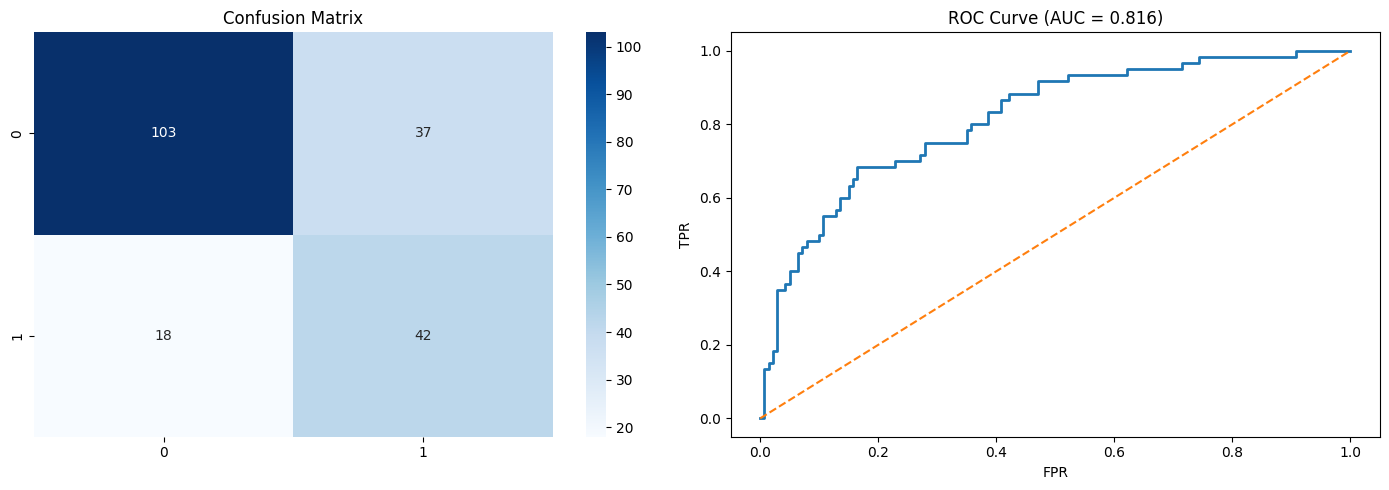


=== FINAL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

 Good Credit       0.85      0.74      0.79       140
  Bad Credit       0.53      0.70      0.60        60

    accuracy                           0.72       200
   macro avg       0.69      0.72      0.70       200
weighted avg       0.76      0.72      0.73       200



In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "SVM (class weights)": SVC(random_state=42, probability=True, class_weight='balanced')
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

print("\n=== CLASSICAL BASELINE RESULTS ===")
results_df = pd.DataFrame(results).T
print(results_df)

best_model_name = results_df['ROC-AUC'].idxmax()
best_model = models[best_model_name]
print("\nBest classical model:", best_model_name)


y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")

plt.subplot(1,2,2)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.3f})")

plt.tight_layout()
plt.show()

print("\n=== FINAL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=["Good Credit", "Bad Credit"]))


##### Feature Importance (Random Forest)

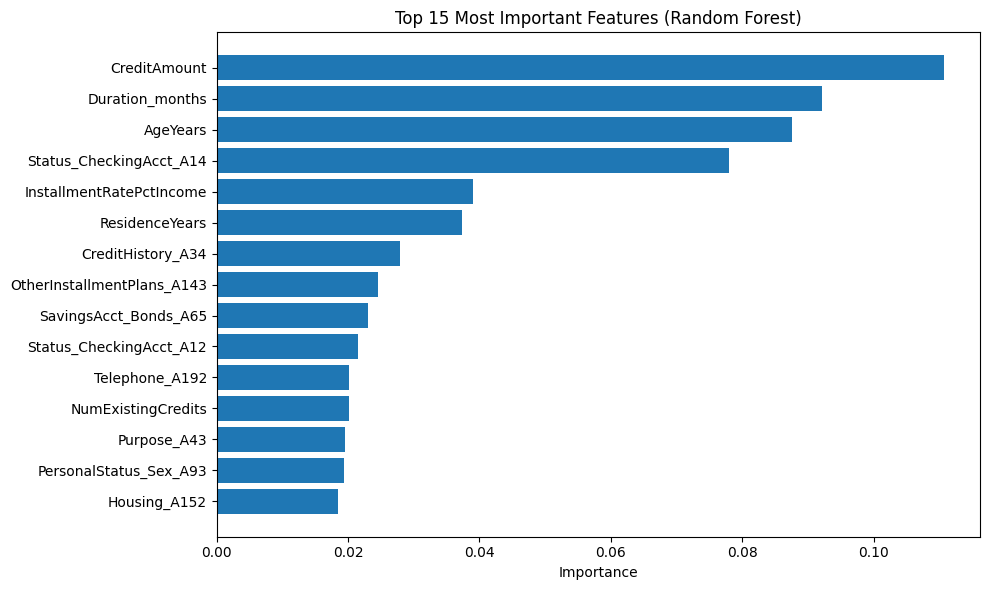

In [9]:
# Feature importance plot
rf = models["Random Forest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X_encoded.columns[indices])
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


##### Correlation Heatmap

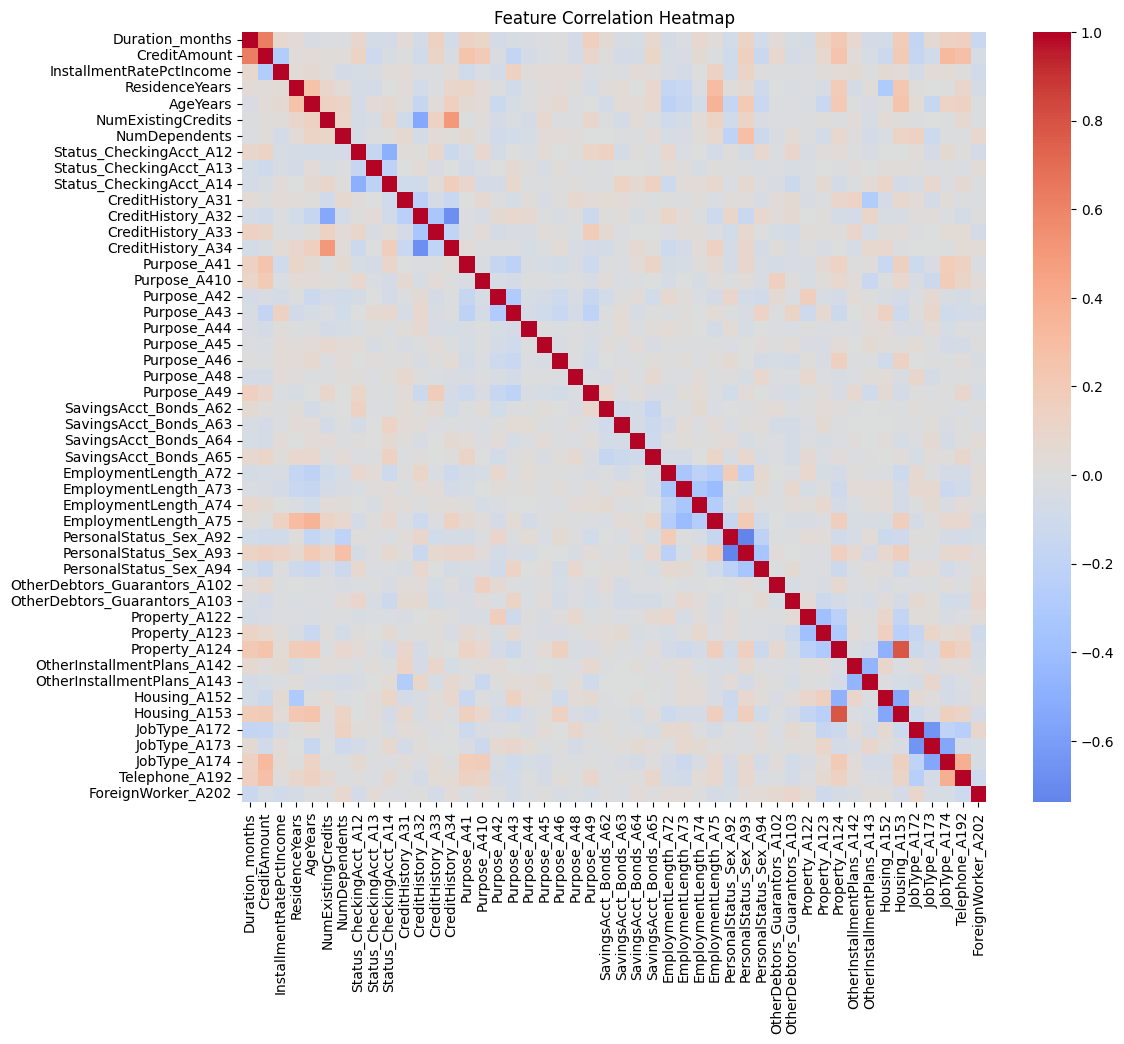

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(X_encoded.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### Defining PD and LGD


=== CLASSICAL EXPECTED LOSS (EL) ===
Expected Portfolio Loss = 262461.74

=== CLASSICAL RISK METRICS (LGD = Credit amount) ===
Expected Loss (EL):        262461.74
Value at Risk (95% VaR):   314244.25
Conditional VaR (95% CVaR): 327929.15


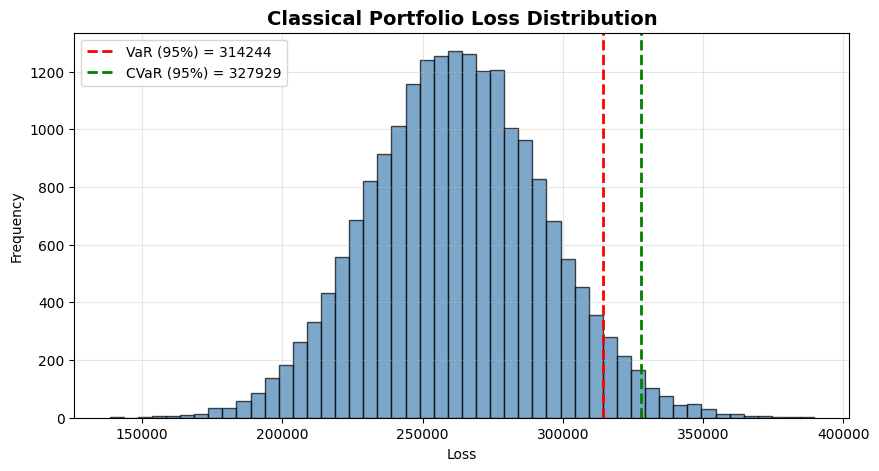

In [11]:
# Extract LGD from the original (unencoded) features
LGD = X.loc[X_test.index, "CreditAmount"].values  # align LGD with test set


# PD from the best classical model
PD = best_model.predict_proba(X_test_scaled)[:, 1]


# Expected loss contribution per borrower
expected_losses = PD * LGD


# ---- 1. EXPECTED LOSS ----
expected_portfolio_loss = expected_losses.sum()
print("\n=== CLASSICAL EXPECTED LOSS (EL) ===")
print(f"Expected Portfolio Loss = {expected_portfolio_loss:.2f}")


# ---- 2. MONTE CARLO LOSS SIMULATION ----
num_simulations = 20000     # can increase for smoother distribution
portfolio_losses = np.zeros(num_simulations)


for i in range(num_simulations):
    defaults = np.random.binomial(1, PD)     # simulate default events
    loss = np.sum(defaults * LGD)
    portfolio_losses[i] = loss


# ---- 3. VaR at 95% ----
alpha = 0.95
VaR_95 = np.percentile(portfolio_losses, alpha * 100)


# ---- 4. CVaR at 95% ----
CVaR_95 = portfolio_losses[portfolio_losses >= VaR_95].mean()


print("\n=== CLASSICAL RISK METRICS (LGD = Credit amount) ===")
print(f"Expected Loss (EL):        {expected_portfolio_loss:.2f}")
print(f"Value at Risk (95% VaR):   {VaR_95:.2f}")
print(f"Conditional VaR (95% CVaR): {CVaR_95:.2f}")


# ---- 5. PLOT LOSS DISTRIBUTION ----
plt.figure(figsize=(10, 5))
plt.hist(portfolio_losses, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(VaR_95, color="red", linewidth=2, linestyle="--", label=f"VaR (95%) = {VaR_95:.0f}")
plt.axvline(CVaR_95, color="green", linewidth=2, linestyle="--", label=f"CVaR (95%) = {CVaR_95:.0f}")
plt.title("Classical Portfolio Loss Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

##### PD Distribution Plot

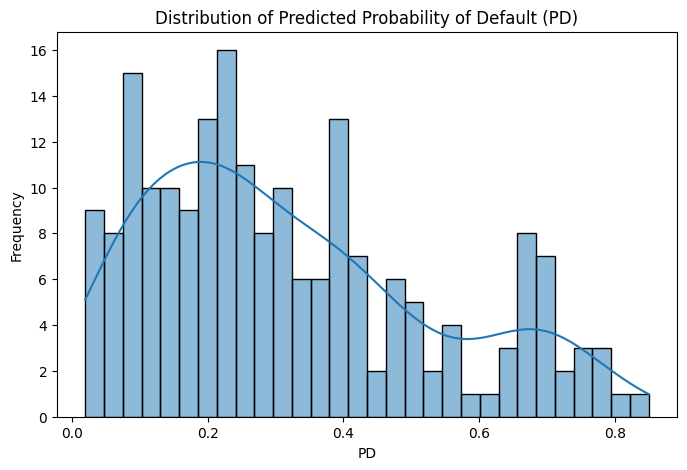

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(PD, bins=30, kde=True)
plt.title("Distribution of Predicted Probability of Default (PD)")
plt.xlabel("PD")
plt.ylabel("Frequency")
plt.show()


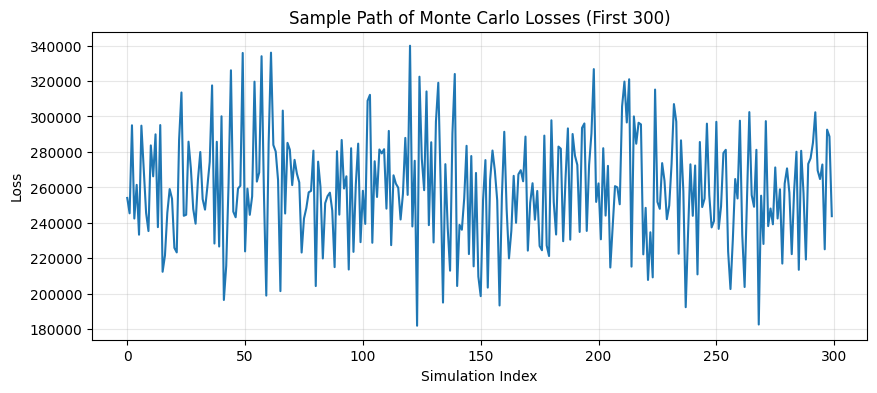

In [13]:
plt.figure(figsize=(10,4))
plt.plot(portfolio_losses[:300])
plt.title("Sample Path of Monte Carlo Losses (First 300)")
plt.xlabel("Simulation Index")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.show()


#### This block extracts a K-asset subset to match the quantum circuit size. It recomputes EL, VaR, and CVaR for the subset to allow a fair classical vs quantum comparison. Monte Carlo simulation is again used for loss estimation.


In [14]:
import numpy as np

# Choose batch size K
K = 10  # Adjust as per your quantum circuit capacity

# Extract PDs and LGDs for the same K assets as in quantum
p_zeros = PD[:K]    # Probability of Default for first K assets
lgd = LGD[:K]       # Loss Given Default for first K assets

# 1) Classical Expected Loss (EL) for the subset
classical_EL_subset = sum(p * l for p, l in zip(p_zeros, lgd))
print(f"Classical Expected Loss (EL) for batch size K={K}: {classical_EL_subset:.2f}")

# 2) Monte Carlo simulation for portfolio loss distribution
num_simulations = 20000
simulated_losses = np.zeros(num_simulations)
for i in range(num_simulations):
    defaults = np.random.binomial(1, p_zeros)
    simulated_losses[i] = np.sum(defaults * lgd)

# 3) Value at Risk (VaR) at 95%
alpha = 0.95
VaR_95 = np.percentile(simulated_losses, alpha * 100)

# 4) Conditional VaR (CVaR) at 95%
tail_losses = simulated_losses[simulated_losses >= VaR_95]
CVaR_95 = tail_losses.mean() if len(tail_losses) > 0 else VaR_95

print(f"Classical 95% VaR for batch size K={K}: {VaR_95:.2f}")
print(f"Classical 95% CVaR for batch size K={K}: {CVaR_95:.2f}")


Classical Expected Loss (EL) for batch size K=10: 8314.79
Classical 95% VaR for batch size K=10: 15496.00
Classical 95% CVaR for batch size K=10: 16783.17


#### This cell builds a quantum Expected Loss estimator using Qiskit. It encodes PDs into qubit amplitudes with Ry rotations, applies a WeightedAdder to aggregate scaled LGDs, and uses a LinearAmplitudeFunction as the objective. Iterative Amplitude Estimation (IAE) runs on the Aer simulator to estimate EL along with a 95% confidence interval, enabling comparison to classical results.


In [15]:
# === Parameters ===
K = 10  # number of assets / qubits
p_zeros = PD[:K]    # PDs subset
lgd = LGD[:K]       # LGDs subset

# Classical EL for reference
classical_EL = sum(p * l for p, l in zip(p_zeros, lgd))
print(f"Classical Expected Loss (EL): {classical_EL:.2f}")

# Fine-grained scaling of LGD (smaller scale factor increases integer precision)
max_lgd = max(lgd)
scale_factor = max_lgd / 20.0 if max_lgd else 1.0
weights_scaled = [int(round(val / scale_factor)) for val in lgd]

# Create WeightedAdder and LinearAmplitudeFunction with scaled weights
agg = WeightedAdder(K, weights_scaled)

objective = LinearAmplitudeFunction(
    num_state_qubits=agg.num_sum_qubits,
    slope=[1], offset=[0],
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(0, sum(weights_scaled)),
    rescaling_factor=1.0,
    breakpoints=[0]
)

Classical Expected Loss (EL): 8314.79


In [16]:
# Quantum registers
qr_state = QuantumRegister(K, "state")
qr_obj = QuantumRegister(1, "objective")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")

n_anc = agg.num_qubits - (K + agg.num_sum_qubits + agg.num_carry_qubits)
qr_anc = QuantumRegister(max(0, n_anc), "ancilla") if n_anc > 0 else None

# Assemble registers efficiently
registers = [qr_state, qr_obj, qr_sum, qr_carry]
if qr_anc:
    registers.append(qr_anc)

qc = QuantumCircuit(*registers, name="state_preparation")

# Encode PDs with Ry rotations (optimized from paper guidance)
for i in range(K):
    theta = 2 * asin(sqrt(p_zeros[i]))
    qc.ry(theta, qr_state[i])

# Apply weighted adder and objective gates
adder_qubits = list(qr_state) + list(qr_sum) + list(qr_carry)
if qr_anc:
    adder_qubits += list(qr_anc)

qc.append(agg.to_gate(), adder_qubits)
qc.append(objective.to_gate(), list(qr_sum) + [qr_obj[0]])
qc.append(agg.to_gate().inverse(), adder_qubits)

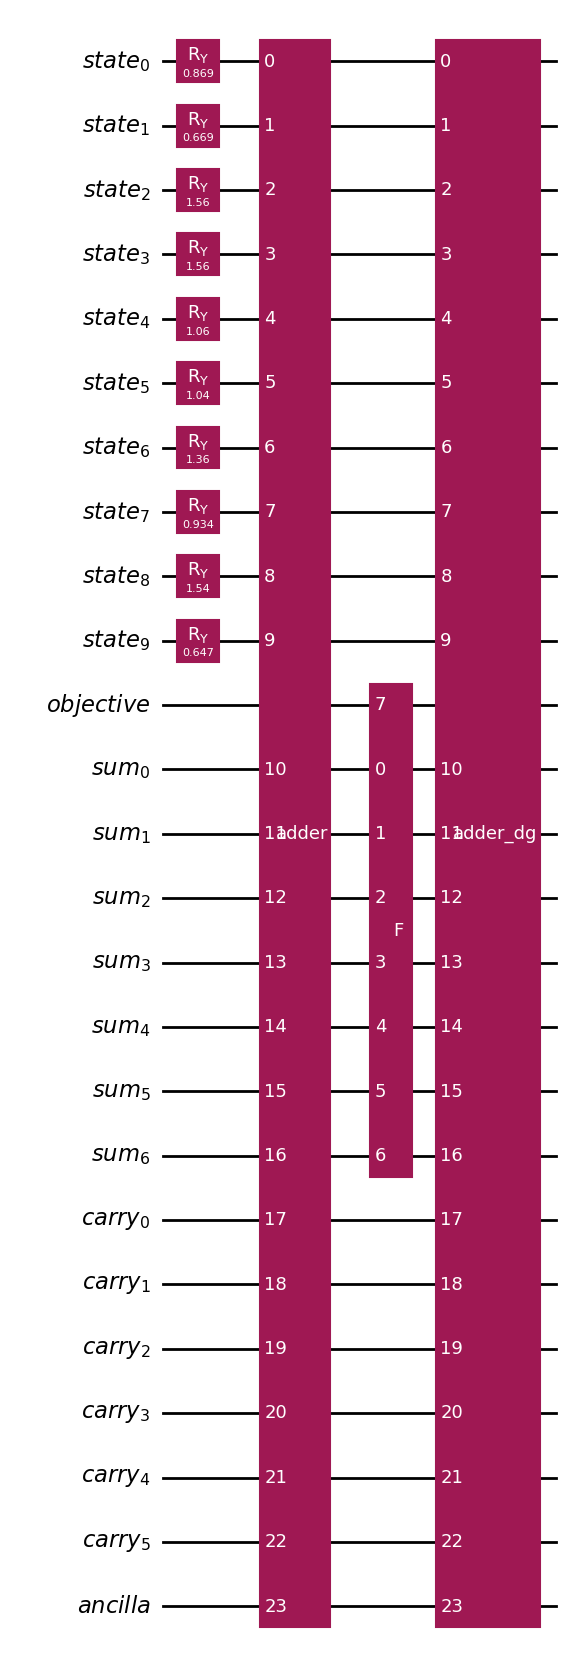

In [17]:
qc.draw('mpl')

In [18]:
# Visualize the quantum circuit
#qc.decompose(reps=2).draw('mpl')        # This code block decomposes the circuit

#### Here we are using Aer simulator and running the circuit using IAE

In [19]:
# Aer Simulator backend
aer_sim = AerSimulator()

fake_backend = FakeParisV2()            # Can be used (time-consuming)

# Transpile circuit optimized for AerSimulator
optimized_circuit = transpile(
    qc,
    backend=aer_sim,
    optimization_level=3
)

# SamplerV2 from backend with appropriate shots and seed
sampler = SamplerV2.from_backend(aer_sim, default_shots=2048, seed=123)

# Build estimation problem
problem = EstimationProblem(
    state_preparation=optimized_circuit,
    objective_qubits=[K],  # objective qubit index
    post_processing=objective.post_processing
)

# Initialize and run IAE with tighter epsilon for better precision
iae = IterativeAmplitudeEstimation(epsilon_target=0.03, alpha=0.05, sampler=sampler)
result = iae.estimate(problem)

quantum_EL = result.estimation_processed * scale_factor  # scale back to original LGD units
ci_low, ci_high = np.array(result.confidence_interval_processed) * scale_factor

# Output results
print(f"Quantum Expected Loss (EL): {quantum_EL:.2f}")
print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")

abs_error = abs(quantum_EL - classical_EL)
rel_error = abs_error / classical_EL if classical_EL != 0 else float('inf')
print(f"Absolute error: {abs_error:.2f}")
print(f"Relative error: {rel_error:.2%}")

Quantum Expected Loss (EL): 8684.96
95% Confidence Interval: [8291.43, 9078.49]
Absolute error: 370.17
Relative error: 4.45%
